# Seller Performance & Retention Analytics

## Overview
This project analyzes seller performance, predicts churn risk, and proposes retention strategies for an e-commerce marketplace like Meesho.

## Objectives
- Identify seller retention patterns via cohort analysis
- Predict churn risk using machine learning
- Segment sellers into risk tiers
- Simulate GMV uplift from retention interventions

## Data
- **sellers.csv**: seller_id, onboard_date
- **performance.csv**: seller_id, month, orders, returns, revenue, active

Synthetic data is generated by default; replace with real CSVs for production.

## Methodology
1. **Cohort Analysis**: Group sellers by onboarding month, calculate retention rates.
2. **Churn Prediction**: Train a Random Forest model on recent performance metrics.
3. **Risk Segmentation**: Classify sellers into Low, Medium, High risk tiers.
4. **What-If Simulation**: Estimate GMV uplift from improved retention.

## How to Run
- Open in Google Colab
- Set `USE_CUSTOM_DATA = True` to use your own CSVs
- Run cells sequentially

## Outputs
- Retention heatmap
- Churn model metrics (classification report, ROC AUC)
- Risk tier distribution
- GMV uplift simulation

## Business Impact
- Targeted retention campaigns
- Reduced seller churn
- Increased GMV and seller lifetime value


In [1]:
# Install dependencies
!pip -q install pandas numpy matplotlib seaborn scikit-learn plotly sqlalchemy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
print("Environment ready.")


Environment ready.


In [2]:
# Toggle to use your own CSVs
USE_CUSTOM_DATA = False

if not USE_CUSTOM_DATA:
    # Synthetic seller dataset
    n_sellers = 500
    start_dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")
    sellers = pd.DataFrame({
        "seller_id": [f"S{i:04d}" for i in range(1, n_sellers+1)],
        "onboard_date": np.random.choice(start_dates, n_sellers)
    })

    # Monthly performance metrics
    months = pd.date_range("2023-01-01", "2024-06-30", freq="MS")
    perf_rows = []
    for _, s in sellers.iterrows():
        for m in months:
            if m >= s["onboard_date"]:
                orders = np.random.poisson(lam=np.random.randint(5, 50))
                returns = np.random.binomial(orders, p=0.05)
                revenue = orders * np.random.uniform(200, 800)
                active = np.random.choice([1, 0], p=[0.9, 0.1])  # active flag
                perf_rows.append({
                    "seller_id": s["seller_id"],
                    "month": m,
                    "orders": orders,
                    "returns": returns,
                    "revenue": revenue,
                    "active": active
                })
    performance = pd.DataFrame(perf_rows)
else:
    sellers = pd.read_csv("/content/sellers.csv", parse_dates=["onboard_date"])
    performance = pd.read_csv("/content/performance.csv", parse_dates=["month"])

print(sellers.head(), performance.head())


  seller_id onboard_date
0     S0001   2023-04-13
1     S0002   2023-12-15
2     S0003   2023-09-28
3     S0004   2023-04-17
4     S0005   2023-03-13   seller_id      month  orders  returns       revenue  active
0     S0001 2023-05-01       5        0   2636.850368       0
1     S0001 2023-06-01       6        0   2411.595174       1
2     S0001 2023-07-01      40        3  14764.514595       1
3     S0001 2023-08-01      63        3  49174.544847       1
4     S0001 2023-09-01      46        6  20588.247883       1


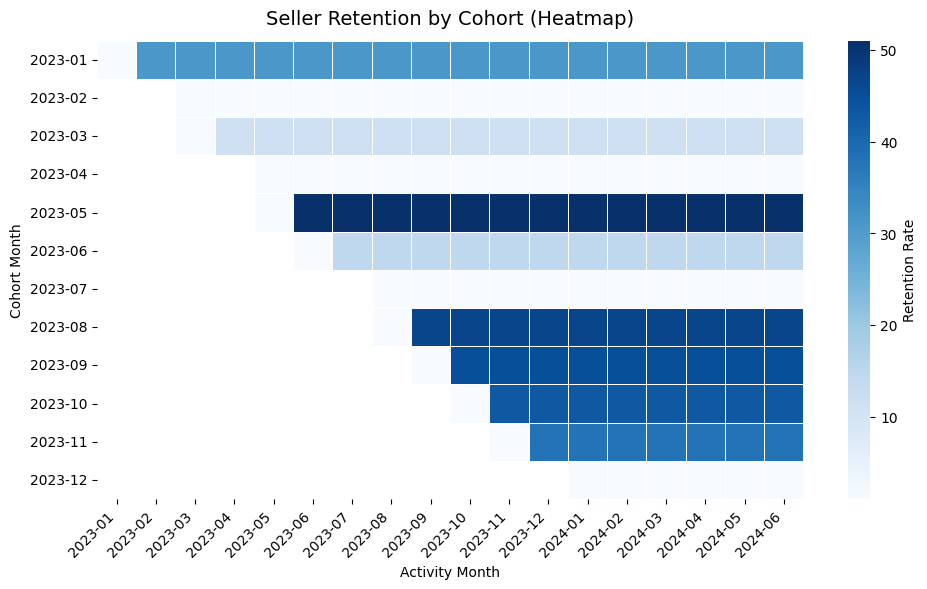

In [8]:
# Pivot table for retention (same as before)
cohort_sizes = cohort_data.groupby("cohort_month")["seller_id"].first()
retention = cohort_data.pivot(index="cohort_month", columns="month", values="seller_id").divide(cohort_sizes, axis=0)

# Convert Period to string for better plotting
retention.index = retention.index.astype(str)
retention.columns = retention.columns.strftime('%Y-%m')

plt.figure(figsize=(10,6))
sns.heatmap(
    retention,
    cmap="Blues",
    cbar_kws={'label': 'Retention Rate'},
    annot=False,        # no per-cell text
    linewidths=0.5,     # thin grid lines for clarity
    linecolor='white'
)

plt.title("Seller Retention by Cohort (Heatmap)", fontsize=14, pad=12)
plt.xlabel("Activity Month")
plt.ylabel("Cohort Month")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [4]:
# Define churn: inactive in last recorded month
latest_month = performance["month"].max()
last_status = performance[performance["month"] == latest_month][["seller_id", "active"]]
last_status["churn"] = 1 - last_status["active"]

# Aggregate features over last 3 months
cutoff = latest_month - pd.DateOffset(months=3)
recent = performance[performance["month"] > cutoff]
features = recent.groupby("seller_id").agg({
    "orders": "mean",
    "returns": "mean",
    "revenue": "mean",
    "active": "mean"
}).reset_index()

df_model = features.merge(last_status[["seller_id", "churn"]], on="seller_id")

X = df_model.drop(columns=["seller_id", "churn"])
y = df_model["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94        92
           1       0.17      0.12      0.14         8

    accuracy                           0.88       100
   macro avg       0.55      0.54      0.54       100
weighted avg       0.86      0.88      0.87       100

ROC AUC: 0.8125


In [5]:
# Define churn: inactive in last recorded month
latest_month = performance["month"].max()
last_status = performance[performance["month"] == latest_month][["seller_id", "active"]]
last_status["churn"] = 1 - last_status["active"]

# Aggregate features over last 3 months
cutoff = latest_month - pd.DateOffset(months=3)
recent = performance[performance["month"] > cutoff]
features = recent.groupby("seller_id").agg({
    "orders": "mean",
    "returns": "mean",
    "revenue": "mean",
    "active": "mean"
}).reset_index()

df_model = features.merge(last_status[["seller_id", "churn"]], on="seller_id")

X = df_model.drop(columns=["seller_id", "churn"])
y = df_model["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94        92
           1       0.17      0.12      0.14         8

    accuracy                           0.88       100
   macro avg       0.55      0.54      0.54       100
weighted avg       0.86      0.88      0.87       100

ROC AUC: 0.8125


In [6]:
# Risk tiers based on churn probability
df_model["churn_prob"] = model.predict_proba(X)[:,1]
df_model["risk_tier"] = pd.cut(df_model["churn_prob"], bins=[0,0.33,0.66,1], labels=["Low","Medium","High"])

risk_summary = df_model["risk_tier"].value_counts(normalize=True) * 100
print("Risk tier distribution (%):\n", risk_summary)

fig = px.histogram(df_model, x="churn_prob", color="risk_tier", nbins=20, title="Seller Churn Probability Distribution")
fig.show()


Risk tier distribution (%):
 risk_tier
Low       79.910714
High      12.500000
Medium     7.589286
Name: proportion, dtype: float64


In [7]:
def simulate_retention_boost(boost_pct=0.1):
    """Simulate GMV uplift if high-risk sellers improve retention by boost_pct."""
    high_risk = df_model[df_model["risk_tier"]=="High"]
    avg_rev = features["revenue"].mean()
    recovered_sellers = int(len(high_risk) * boost_pct)
    uplift = recovered_sellers * avg_rev * 3  # 3 months projection
    return uplift

print("GMV uplift if 10% of high-risk sellers retained:", simulate_retention_boost(0.1))


GMV uplift if 10% of high-risk sellers retained: 80628.57789568361
